In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
import optuna
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
ESR = pd.read_csv('C:/Users/darry/Downloads/invut/Epileptic Seizure Recognition.csv')


In [3]:
# Binary classification: 0 for non-seizure, 1 for seizure
y = (ESR.iloc[:, 179].values > 1).astype(int)
X = ESR.iloc[:, 1:179].values

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Standardize the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Reshape the data for 1D CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [6]:
# Define hyperparameter space
filter_sizes = [16, 32, 64]
kernel_sizes = [3, 4, 5]
pool_sizes = [2, 3]
dense_units = [8, 16, 32]

# Ant Colony Optimization
n_ants = 5
n_iterations = 10

best_params = None
best_accuracy = 0.0

In [7]:
for _ in range(n_iterations):
    for ant in range(n_ants):
        # Randomly initialize parameters
        n_filters = np.random.choice(filter_sizes)
        kernel_size = int(np.random.choice(kernel_sizes, size=1)[0])
        pool_size = int(np.random.choice(pool_sizes, size=1)[0])
        dense_unit = np.random.choice(dense_units)

        # Build the model
        model = Sequential()
        model.add(Conv1D(n_filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Flatten())
        model.add(Dense(dense_unit, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

        # Evaluate the model on the validation set
        _, accuracy = model.evaluate(X_test, y_test, verbose=0)

        # Update best parameters if necessary
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'n_filters': n_filters, 'kernel_size': kernel_size, 'pool_size': pool_size, 'dense_unit': dense_unit}

In [8]:
# Build the final model with the best hyperparameters
final_model = Sequential()
final_model.add(Conv1D(best_params['n_filters'], kernel_size=best_params['kernel_size'], activation='relu', input_shape=(X_train.shape[1], 1)))
final_model.add(MaxPooling1D(pool_size=best_params['pool_size']))
final_model.add(Flatten())
final_model.add(Dense(best_params['dense_unit'], activation='relu'))
final_model.add(Dense(1, activation='sigmoid'))

In [9]:
# Compile the final model
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Train the final model
final_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
288/288 [==============================] - 3s 8ms/step - loss: 0.1856 - accuracy: 0.9279 - val_loss: 0.0880 - val_accuracy: 0.9613
Epoch 2/10
288/288 [==============================] - 2s 8ms/step - loss: 0.0916 - accuracy: 0.9646 - val_loss: 0.0755 - val_accuracy: 0.9691
Epoch 3/10
288/288 [==============================] - 2s 7ms/step - loss: 0.0713 - accuracy: 0.9724 - val_loss: 0.0770 - val_accuracy: 0.9683
Epoch 4/10
288/288 [==============================] - 2s 7ms/step - loss: 0.0594 - accuracy: 0.9779 - val_loss: 0.0601 - val_accuracy: 0.9783
Epoch 5/10
288/288 [==============================] - 2s 8ms/step - loss: 0.0482 - accuracy: 0.9812 - val_loss: 0.0587 - val_accuracy: 0.9796
Epoch 6/10
288/288 [==============================] - 2s 8ms/step - loss: 0.0413 - accuracy: 0.9853 - val_loss: 0.0650 - val_accuracy: 0.9774
Epoch 7/10
288/288 [==============================] - 2s 8ms/step - loss: 0.0371 - accuracy: 0.9872 - val_loss: 0.0625 - val_accuracy: 0.9761
Epoch 

In [11]:
# Evaluate the final model
_, accuracy_final = final_model.evaluate(X_test, y_test)
print('Test Accuracy with Optimal Hyperparameters:', accuracy_final)
print('Best Hyperparameters:', best_params)

72/72 [==============================] - 0s 4ms/step - loss: 0.0656 - accuracy: 0.9796
Test Accuracy with Optimal Hyperparameters: 0.9795652031898499
Best Hyperparameters: {'n_filters': 64, 'kernel_size': 4, 'pool_size': 2, 'dense_unit': 32}


72/72 [==============================] - 0s 3ms/step
Confusion Matrix:
[[ 441   24]
 [  23 1812]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       465
           1       0.99      0.99      0.99      1835

    accuracy                           0.98      2300
   macro avg       0.97      0.97      0.97      2300
weighted avg       0.98      0.98      0.98      2300


Test Accuracy with Optimal Hyperparameters: 0.9795652173913043
Best Hyperparameters: {'n_filters': 64, 'kernel_size': 4, 'pool_size': 2, 'dense_unit': 32}


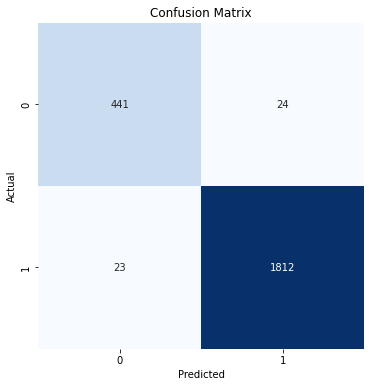

In [14]:
y_pred = final_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Display confusion matrix
print("Confusion Matrix:")
print(conf_mat)

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Display additional metrics
accuracy_final = accuracy_score(y_test, y_pred_classes)
print('\nTest Accuracy with Optimal Hyperparameters:', accuracy_final)
print('Best Hyperparameters:', best_params)

# Display confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sn.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()